# 1. Producing the data (30%)

In this task, we will implement Apache Kafka producers to simulate the real-time streaming of the flight data.


**Important:**
- In this task, you need to generate the event timestamp in UTC timezone for each data
record in the producer, and then convert the timestamp to unix-timestamp format
(keeping UTC timezone) to simulate the “ts” column. For example, if the current time
is 2021-9-28 12:39:45 UTC, it should be converted to the value of 1632796806, and
stored in the “ts” column
- **Please do not use Spark in this task**

## 1.2 Memory Event Producer (15%)
Write a python program that loads all the data from “flight*.csv”. Save the file as
Assignment-2B-Task1_flight_producer.ipynb.
Your program should send X number and Y number of records from each producer
following the sequence to the Kafka stream every 5 seconds. X represents the records to
send in a particular batch, whereas Y represents the records to send in the next batch (pending
records). The sequence of the batch is depicted in Fig.1.


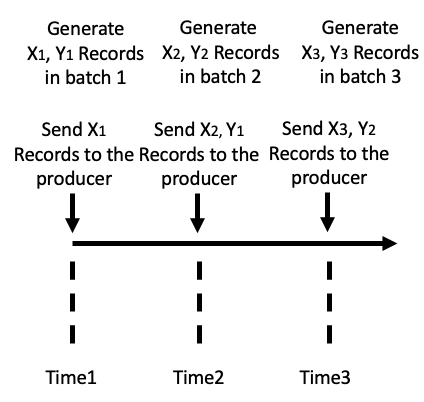

                            Fig.1. Sequence of data generation in flight-data into stream

### Start the Kafka Service

In [1]:
# Run this to start kafka server.
!echo student  | sudo -S systemctl start kafka.service

[sudo] password for student: 

In [2]:
# Check the status of Kafka server.
# !echo student | sudo -S systemctl status kafka.service

### Import libraries

In [3]:
# Libraries used
from time import sleep
from json import dumps
from kafka import KafkaProducer
import random
import datetime as dt
import csv
import pandas as pd
import os

### Data Preparation 

In [4]:
# Topic creation
topic = "flightTopic"
# Set delay
delay = 5

In [5]:
# Load all the files from Flight directory.
files = os.listdir("flight-delays/")
files = ["flight-delays/" + f for f in files if f != "airports.csv"]
flightdf = pd.concat(map(pd.read_csv, files), ignore_index=True)

In [6]:
# Remove unwanted columns and remove na values
flightdf = flightdf[
    [
        "YEAR",
        "MONTH",
        "DAY",
        "DAY_OF_WEEK",
        "AIRLINE",
        "FLIGHT_NUMBER",
        "TAIL_NUMBER",
        "ORIGIN_AIRPORT",
        "DESTINATION_AIRPORT",
        "SCHEDULED_DEPARTURE",
        "DEPARTURE_TIME",
        "DEPARTURE_DELAY",
        "TAXI_OUT",
        "WHEELS_OFF",
        "SCHEDULED_TIME",
        "ELAPSED_TIME",
        "AIR_TIME",
        "DISTANCE",
        "WHEELS_ON",
        "TAXI_IN",
        "SCHEDULED_ARRIVAL",
        "ARRIVAL_TIME",
        "ARRIVAL_DELAY",
        "DIVERTED",
        "CANCELLED",
    ]
]
flightdf = flightdf.dropna(how="any")

In [7]:
# Get Size of records in each DAY of WEEK
KeyFlights = sorted(list(flightdf.DAY_OF_WEEK.unique()))
# Number of rows for each week
num_of_rows = [len(flightdf[flightdf.DAY_OF_WEEK == w]) for w in KeyFlights]

In [8]:
# Data manupulation function for producer having repeat as
def getFlightRecords(
    dset, dow, nrows, start_index, timestamp=None, rand_limit=(70, 100)
):
    # rows to send and End indexes to send for each batch
    # list to store the Timestamps
    rowids, end_index_list, time_info = [], [], []
    # Iterate over each size of DAY OF WEEK
    for i in range(len(KeyFlights)):
        # Get UTC time
        utc = int(dt.datetime.utcnow().timestamp())
        # Create timestamp
        time_info.append(utc)
        # generate size randomly for each sub-batch
        size = random.randint(rand_limit[0], rand_limit[1])
        # Filter the dataframe based on a given day of week and create Index column
        trimmed = dset[dset.DAY_OF_WEEK == dow[i]].reset_index()
        # Calculate ending index for a given sub-batch
        end_index = start_index[i] + size - 1
        # Check endindex greater than given subbatch data length
        if end_index < nrows[i]:
            # Get the index column to send for a given subbatch
            subids = list(trimmed.loc[start_index[i] : end_index, "index"])
            # Add rows to rows list
            rowids.extend(subids)
        else:
            # Add data till end for the random size generated
            subids = list(trimmed.loc[start_index[i] :, "index"])
            # obtain the start index locations to send for subbatch
            end_index = end_index - nrows[i]
            # Add the rows from start
            subids.extend(list(trimmed.loc[0:end_index, "index"]))
            # append index to be sent.
            rowids.extend(subids)

        # check if the subbatch index match to extact data length
        if (end_index + 1) == nrows[i]:
            # Add 0 as dow endindex list
            end_index_list.append(0)
        else:
            # Add the endindex for subbatch for a given dow.
            end_index_list.append(end_index + 1)

    # Filter data based on rowids
    trimmed = dset.iloc[rowids, :].copy()
    # Add timestamp for a given batch if sent from X to Y
    if timestamp is None:
        trimmed["ts"] = trimmed.apply(
            lambda x: time_info[int(x["DAY_OF_WEEK"]) - 1], axis=1
        )
    else:
        trimmed["ts"] = trimmed.apply(
            lambda x: timestamp[int(x["DAY_OF_WEEK"]) - 1], axis=1
        )
    # Convert the dataframe to dictionary
    flightRecords = trimmed.to_dict(orient="records")
    # Return the data
    return flightRecords, end_index_list, time_info

### Kakfa Connection establishment

In [9]:
# publish message function
def publishData(producer_instance, topic_name, data):
    try:
        # send data using producer
        producer_instance.send(topic_name, data)
        print("Message published successfully. Data Size: " + str(len(data)))
    # In case of error
    except Exception as ex:
        print("Exception occured while publishing message.")
        print(str(ex))

In [10]:
# kafka producer connection function
def kafkaConnect(flightProducer=None):
    try:
        print("Connection Established..\n")
        flightProducer = KafkaProducer(
            bootstrap_servers=["localhost:9092"],
            value_serializer=lambda x: dumps(x).encode("ascii"),
            api_version=(0, 10),
        )
    except Exception as ex:
        print("Exception occured while connecting to Kafka.")
        print(str(ex))
    finally:
        return flightProducer

### Publish data using Kafka Producer

In [12]:
if __name__ == "__main__":

    print("Sending records..")
    # Connection to kafka producer
    producer = kafkaConnect()
    # Start index list
    ids = [0] * len(KeyFlights)
    # Data to send
    toSend = []
    # Store Timestamp from X to Y
    ts = []
    # Send data every 5 seconds forever
    while True:
        try:
            # Extract X batch data and fetch index
            X, ids, ts = getFlightRecords(
                dset=flightdf, dow=KeyFlights, nrows=num_of_rows, start_index=ids
            )
            # Extract Y batch data and fetch index
            Y, ids, ts = getFlightRecords(
                dset=flightdf,
                dow=KeyFlights,
                nrows=num_of_rows,
                start_index=ids,
                rand_limit=(5, 10),
                timestamp=ts,
            )
            # Update data
            toSend.extend(X)
            # Publish the message
            publishData(producer, topic, toSend)
            # Add delay
            sleep(delay)
            # Clear the data
            toSend = []
            # Update data to send Y to simulate data generated for next cycle
            toSend.extend(Y)
        except KeyboardInterrupt:
            print("Transmission Stopped..")
            break

Sending records..
Connection Established..

Message published successfully. Data Size: 590
Message published successfully. Data Size: 638
Message published successfully. Data Size: 605
Message published successfully. Data Size: 653
Message published successfully. Data Size: 599
Message published successfully. Data Size: 649
Message published successfully. Data Size: 636
Message published successfully. Data Size: 633
Message published successfully. Data Size: 643
Message published successfully. Data Size: 663
Message published successfully. Data Size: 622
Message published successfully. Data Size: 665
Message published successfully. Data Size: 651
Message published successfully. Data Size: 673
Message published successfully. Data Size: 671
Message published successfully. Data Size: 670
Message published successfully. Data Size: 605
Message published successfully. Data Size: 645
Message published successfully. Data Size: 652
Message published successfully. Data Size: 639
Message publishe

### Reference

1. https://stackoverflow.com/questions/44996933/using-sudo-inside-jupyter-notebooks-cell
2. https://www.geeksforgeeks.org/how-to-merge-multiple-csv-files-into-a-single-pandas-dataframe/?ref=rp